# DifDif-maps
Følgende viser princippet for at bruge symmetriske- og modalitets-forskelle til at lave en segmentering af AIS infarkter.

In [2]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import morphology
from dipy.align import (affine_registration, center_of_mass, translation, rigid, affine)
from dipy.align.imaffine import AffineMap
from dipy.align.transforms import AffineTransform3D
from dipy.align.imaffine import AffineRegistration

/home/rosengaard/miniforge3/envs/medsam3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
current_directory = os.environ['HOME']
test_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/General_dataset/datasplit/FixedPath/test_data.csv')
df_test = pd.read_csv(test_data_path)

data = []
for i in range(0, len(df_test)):
    data.append([os.path.join(current_directory, df_test["DWI_path"][i]),
                os.path.join(current_directory, df_test["ADC_path"][i]),
                os.path.join(current_directory, df_test["b0"][i]),
                os.path.join(current_directory, df_test["Label_path"][i])])

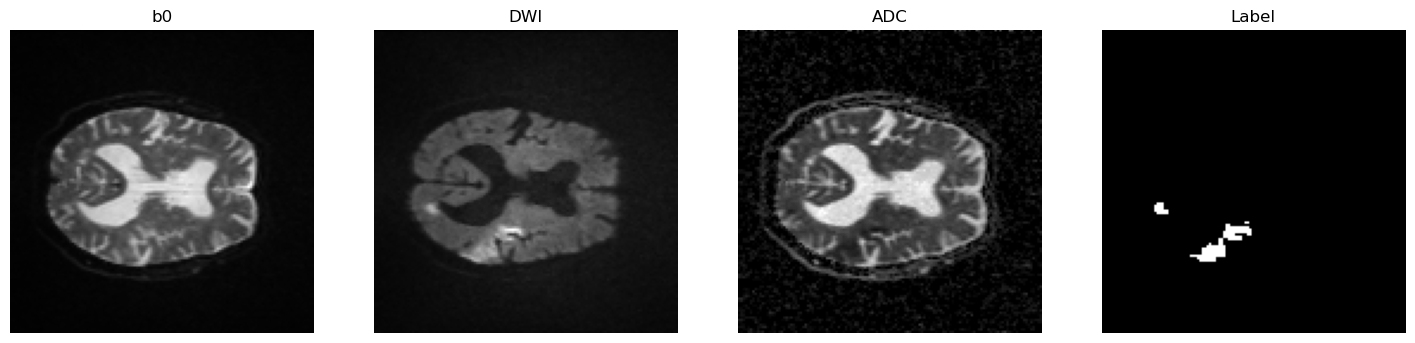

In [12]:
DWI_path, ADC_path, b0_path, label_path = data[2]
DWI_vol = nib.load(DWI_path).get_fdata()
ADC_vol = nib.load(ADC_path).get_fdata()
b0_vol = nib.load(b0_path).get_fdata()
label_vol = nib.load(label_path).get_fdata()

slice_idx = 21
DWI_slice = DWI_vol[:,:,slice_idx]
ADC_slice = ADC_vol[:,:,slice_idx]
b0_slice = b0_vol[:,:,slice_idx]
label_slice = label_vol[:,:,slice_idx]

fig, axes = plt.subplots(1, 4, figsize=(18, 8))
axes[0].imshow(b0_slice, cmap='gray')
axes[0].set_title('b0')
axes[1].imshow(DWI_slice, cmap='gray')
axes[1].set_title('DWI')
axes[2].imshow(ADC_slice, cmap='gray')
axes[2].set_title('ADC')
axes[3].imshow(label_slice, cmap='gray')
axes[3].set_title('Label')
for ax in axes:
    ax.axis('off')

## Højre-venstre-forskel

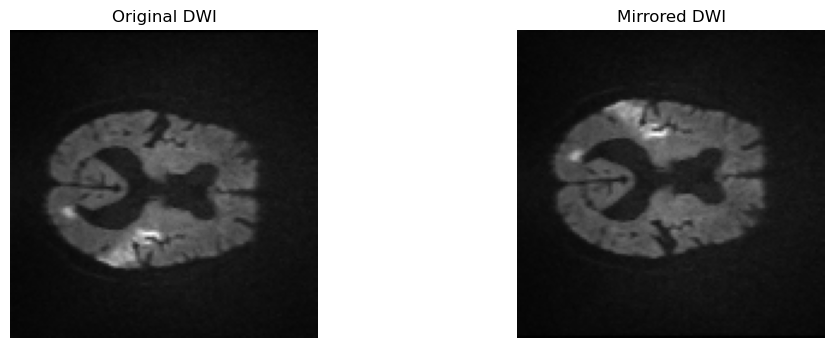

In [4]:
# Mirror the DWI volume horizontally
DWI_vol_mir = np.flipud(DWI_vol)
DWI_slice_mir = DWI_vol_mir[:,:,slice_idx]

# Display the original and mirrored images side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(DWI_slice, cmap='gray')
axes[0].set_title('Original DWI')
axes[1].imshow(DWI_slice_mir, cmap='gray')
axes[1].set_title('Mirrored DWI')
for ax in axes:
    ax.axis('off')
plt.show()

In [7]:
# Register mirrored DWI to DWI
affreg = AffineRegistration(level_iters=[0])
affine3d = affreg.optimize(DWI_vol, DWI_vol_mir, AffineTransform3D(), params0=None)

Optimizing level 0 [max iter: 0]


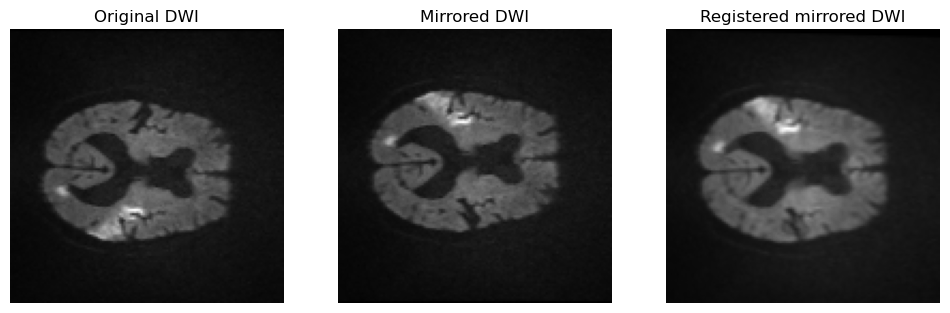

In [8]:
# Overlay
DWI_vol_reg = affine3d.transform(DWI_vol_mir)
DWI_slice_reg = DWI_vol_reg[:,:,slice_idx]

# Display the original and mirrored images side by side using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(DWI_slice, cmap='gray')
axes[0].set_title('Original DWI')
axes[1].imshow(DWI_slice_mir, cmap='gray')
axes[1].set_title('Mirrored DWI')
axes[2].imshow(DWI_slice_reg, cmap='gray')
axes[2].set_title('Registered mirrored DWI')
for ax in axes:
    ax.axis('off')
plt.show()

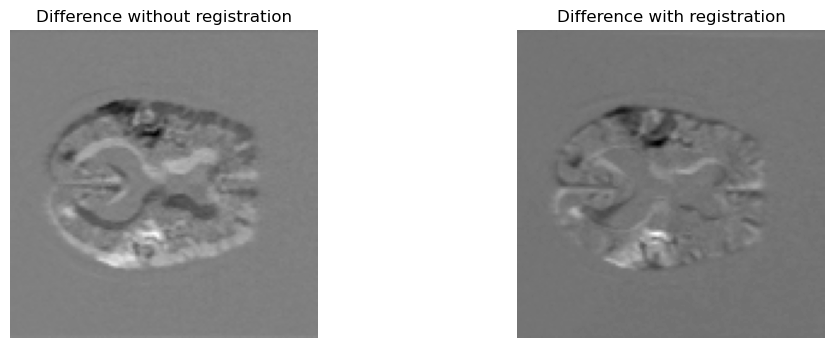

In [9]:
#Difference between mirrored DWI with and without registration
dif_slice1 = DWI_slice - DWI_slice_mir
dif_slice2 = DWI_slice - DWI_slice_reg

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(dif_slice1 , cmap='gray')
axes[0].set_title('Difference without registration')
axes[1].imshow(dif_slice2, cmap='gray')
axes[1].set_title('Difference with registration')
for ax in axes:
    ax.axis('off')
plt.show()

## Modalitets forskel mellem ADC og b0

(-0.5, 127.5, 127.5, -0.5)

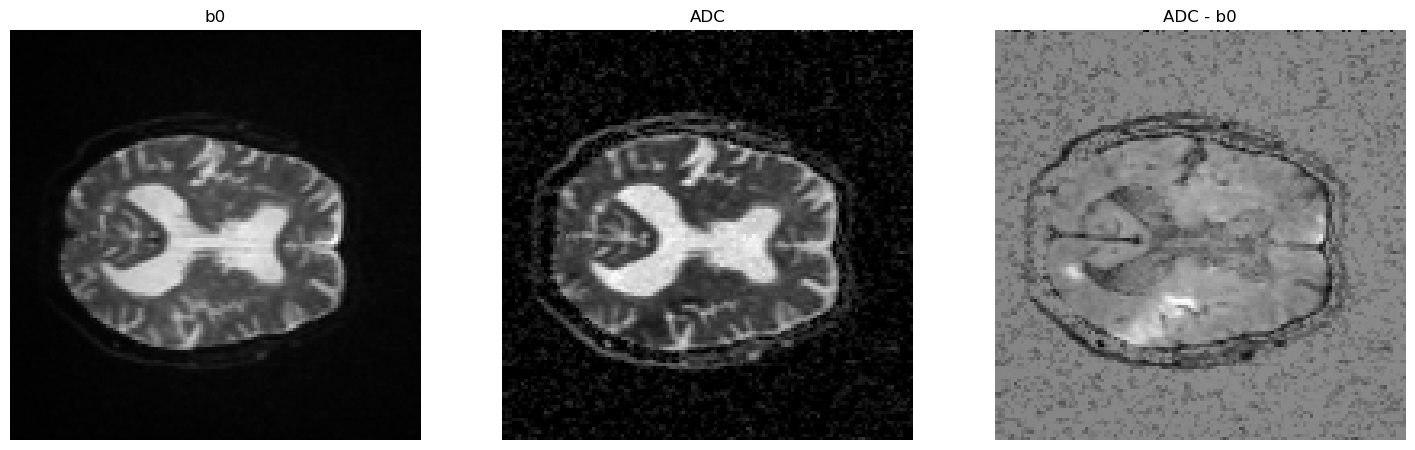

In [38]:
# Forskel på ADC og b0
ADC_slice = (ADC_slice - np.min(ADC_slice)) / (np.max(ADC_slice) - np.min(ADC_slice))
b0_slice = (b0_slice - np.min(b0_slice)) / (np.max(b0_slice) - np.min(b0_slice))

modality_dif = b0_slice - ADC_slice

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes[0].imshow(b0_slice, cmap='gray')
axes[0].set_title('b0')
axes[1].imshow(ADC_slice, cmap='gray')
axes[1].set_title('ADC')
axes[2].imshow(modality_dif, cmap='gray')
axes[2].set_title('ADC - b0')
for ax in axes:
    ax.axis('off')
plt.show()

# Kombineret forskelle: DifDif_maps

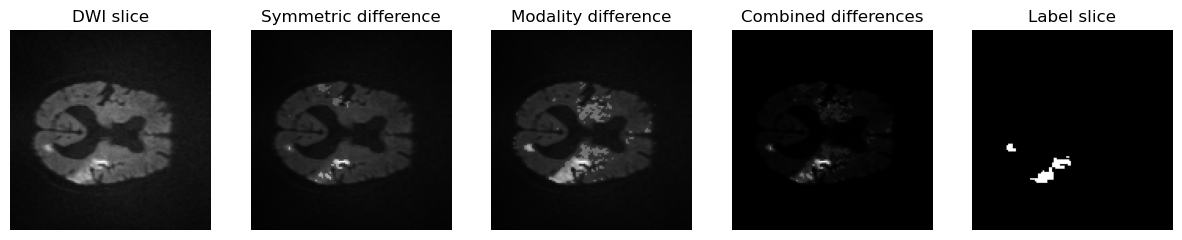

In [56]:
# Compute the symmetric difference of left and right hemisphere from DWI:
Sym_dif_slice  = (DWI_slice_reg - np.min(DWI_slice_reg)) / (np.max(DWI_slice_reg) - np.min(DWI_slice_reg))
Sym_dif_slice = np.where(((Sym_dif_slice*-1+1) < DWI_slice), DWI_slice, DWI_slice*0.5)

# Compute the difference between the modalities ADC and b0:
b0_th = np.where(DWI_slice > (np.mean(DWI_slice)), b0_slice, 0)
ADC_th = np.where(DWI_slice > (np.mean(DWI_slice)), ADC_slice, 0)
modalityDif_slice = np.where(b0_th > ADC_th, DWI_slice, DWI_slice*0.5)

# Compute a dif_dif slice based on the difference between the to dif_slices:
dif_dif_map = Sym_dif_slice * modalityDif_slice

# Plot:
fig, axes = plt.subplots(1, 5, figsize=(15, 8))
axes[0].imshow(DWI_slice, cmap='gray')
axes[0].set_title('DWI slice')
axes[1].imshow(Sym_dif_slice, cmap='gray')
axes[1].set_title('Symmetric difference')
axes[2].imshow(modalityDif_slice, cmap='gray')
axes[2].set_title('Modality difference')
axes[3].imshow(dif_dif_map, cmap='gray')
axes[3].set_title('Combined differences')
axes[4].imshow(label_slice, cmap='gray')
axes[4].set_title('Label slice')
for ax in axes:
    ax.axis('off')
plt.show()

## Eksempel på en simpel metode der baseret på at bruge symetriske- og modalitets-forskelle til at lave en segmentering:

In [59]:
#Load data:
test_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/General_dataset/datasplit/FixedPath/test_data.csv')
df_test = pd.read_csv(test_data_path)

data = []
for i in range(0, len(df_test)):
    data.append([os.path.join(current_directory, df_test["DWI_path"][i]),
                os.path.join(current_directory, df_test["ADC_path"][i]),
                os.path.join(current_directory, df_test["b0"][i]),
                os.path.join(current_directory, df_test["Label_path"][i])])

DWI_path, ADC_path, b0_path, label_path = data[2]
DWI_vol = nib.load(DWI_path).get_fdata()
ADC_vol = nib.load(ADC_path).get_fdata()
b0_vol = nib.load(b0_path).get_fdata()
label_vol = nib.load(label_path).get_fdata()

# Create symDif-map:
# Mirror the DWI volume horizontally
DWI_vol_mir = np.flipud(DWI_vol)

# Register mirrored DWI:
affine3d = affreg.optimize(DWI_vol, DWI_vol_mir, AffineTransform3D(), params0=None) 
DWI_vol_reg = affine3d.transform(DWI_vol_mir)

Optimizing level 0 [max iter: 0]


In [62]:
def DifDif_segmentation(g1):
    # Use modality differences:
    b0_temp = b0_slice > b0_slice.mean()
    ADC_temp = ADC_slice < ADC_slice.mean()*g1
    _modDif = ADC_temp & b0_temp # Binary: 1 if same

    # Use symetric differences:
    _DWI_slice = (DWI_slice- np.min(DWI_slice)) / (np.max(DWI_slice) - np.min(DWI_slice))
    _DWI_slice_reg = (DWI_slice_reg - np.min(DWI_slice_reg)) / (np.max(DWI_slice_reg) - np.min(DWI_slice_reg))
    symDif = _DWI_slice - _DWI_slice_reg
    symDif = np.where((symDif > np.mean(symDif)), symDif, 0)
    _symDif = symDif > np.mean(_DWI_slice_reg) # Binary: threshholding

    # Create DifDif_map:
    _difDif = _symDif & _modDif #And: 1 if same

    # Remove regions with low intensity in the DWI slice and high intensity in the ADC slice:
    _ADC_slice = (ADC_slice - np.min(ADC_slice)) / (np.max(ADC_slice) - np.min(ADC_slice))
    TH = np.where((_DWI_slice > 0.5) & (_ADC_slice < 0.5), 1, 0)
    _difDif = _difDif & TH

    return _symDif, _modDif, _difDif

Dice: 0.095


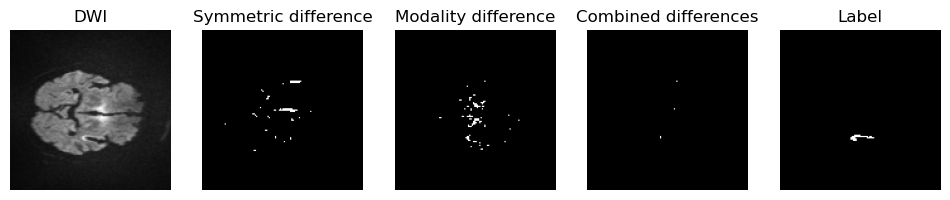

Dice: 0.415


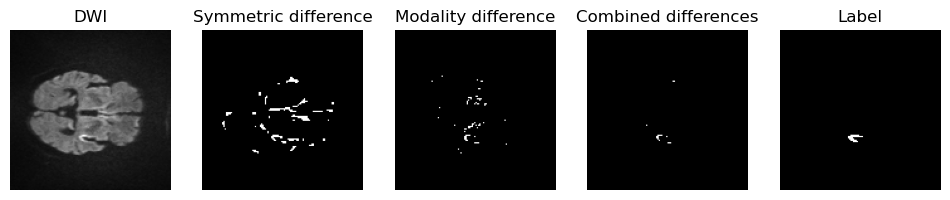

Dice: 0.5


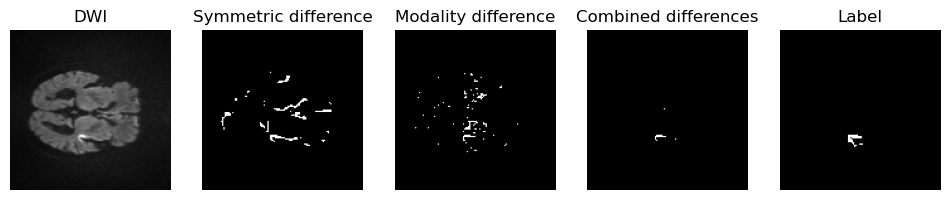

Dice: 0.727


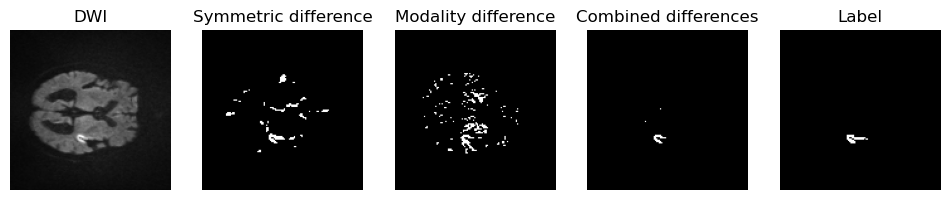

Dice: 0.75


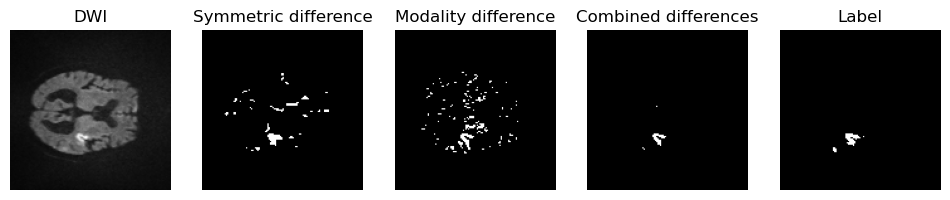

Dice: 0.577


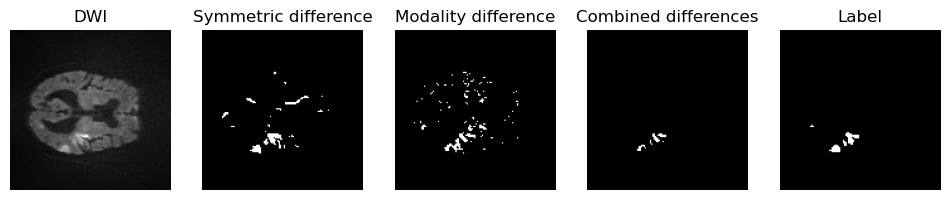

Dice: 0.705


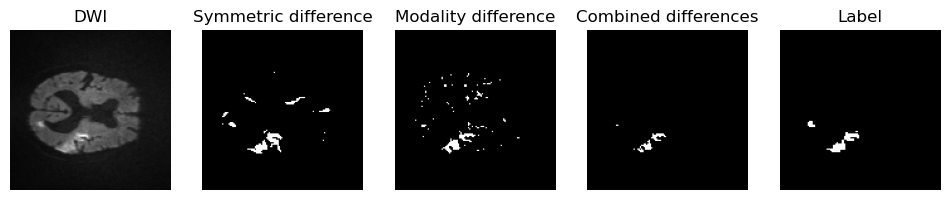

Dice: 0.741


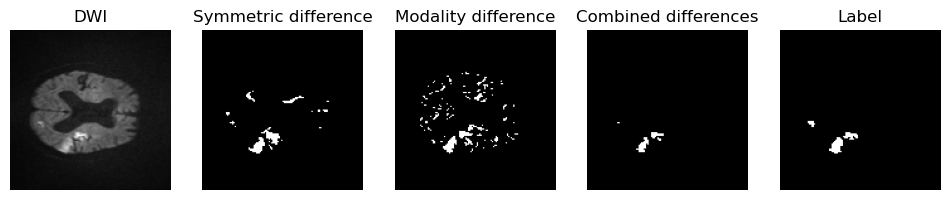

Dice: 0.703


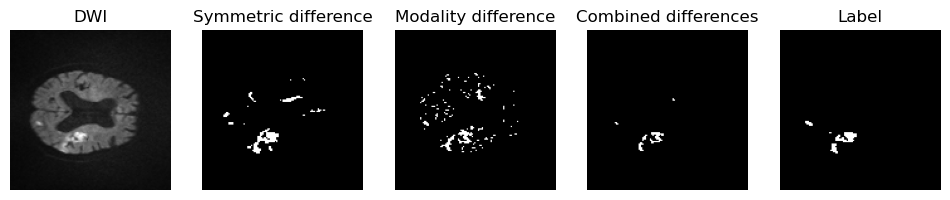

Dice: 0.5


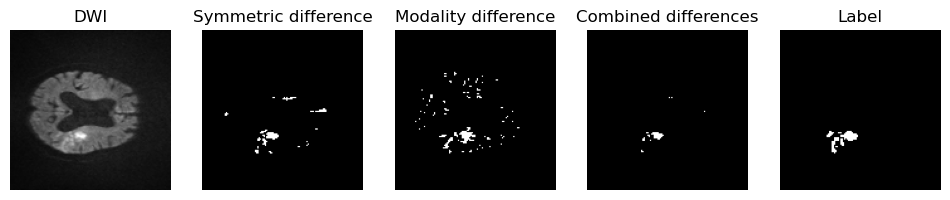

Dice: 0.333


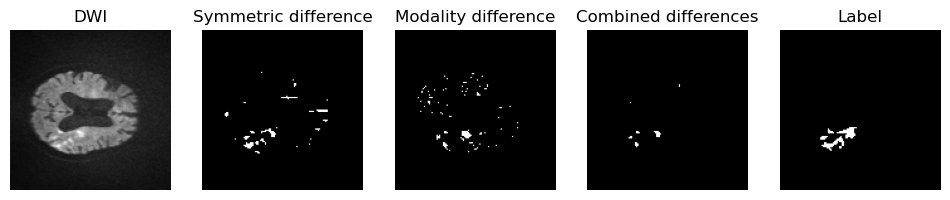

Dice: 0.33


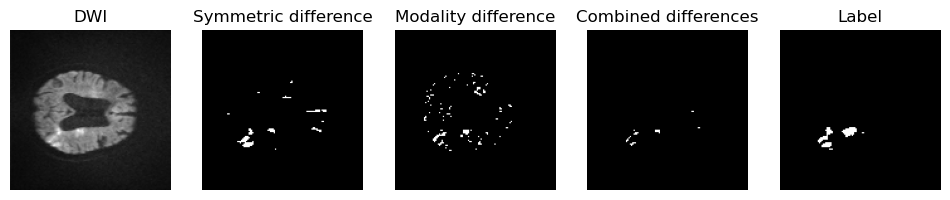

Dice: 0.389


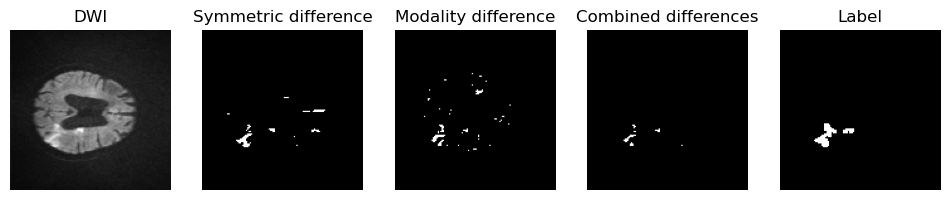

Dice: 0.322


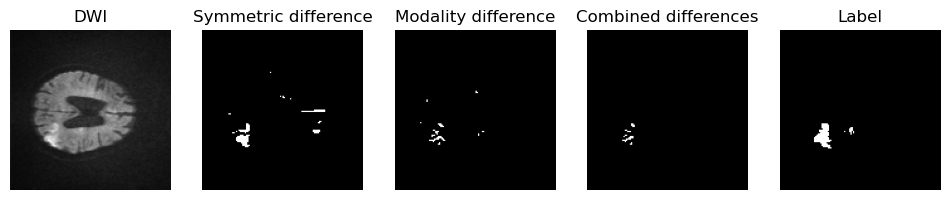

Dice: 0.235


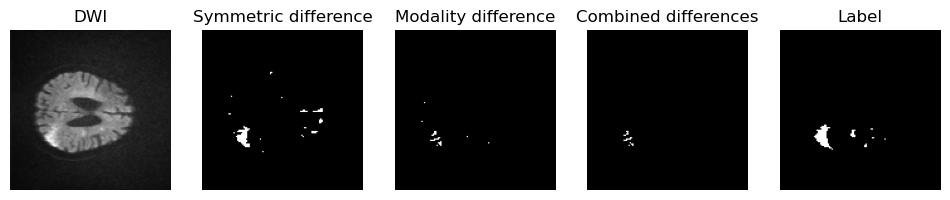

Dice: 0.168


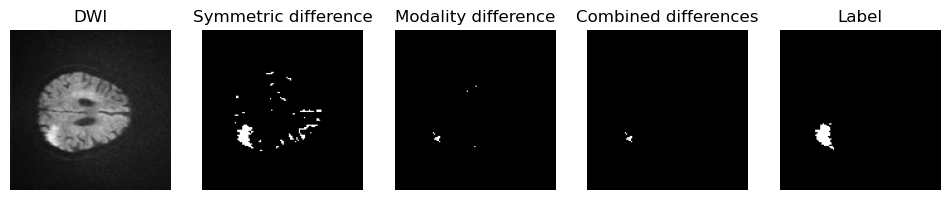

Dice: 0.04


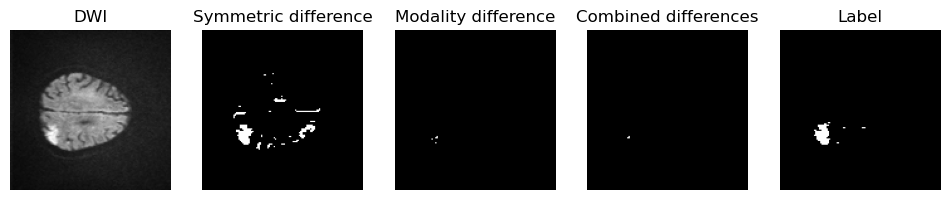

Dice: 0.02


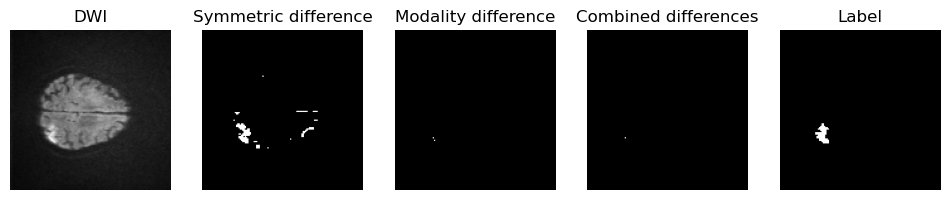

Dice: 0.024


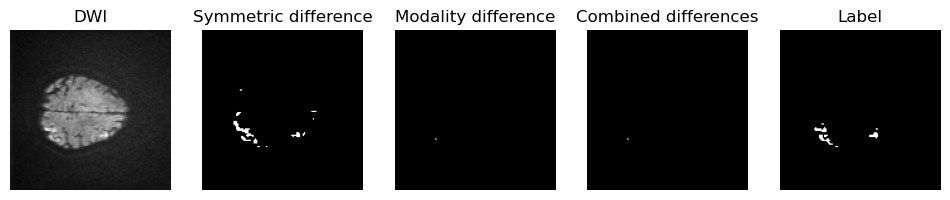

Dice: 0.0


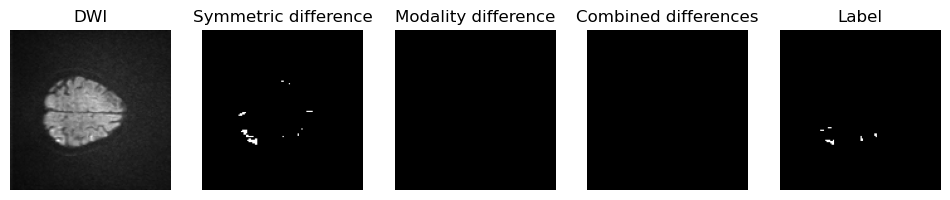

Dice: 0.0


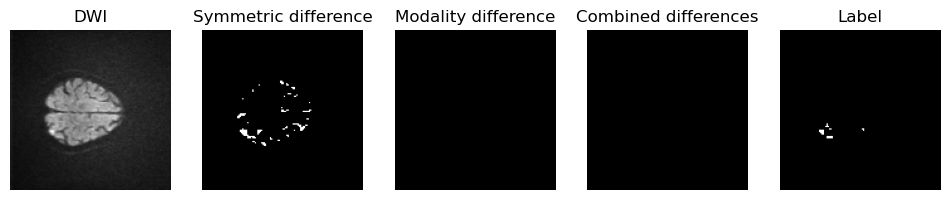

Dice: 0.0


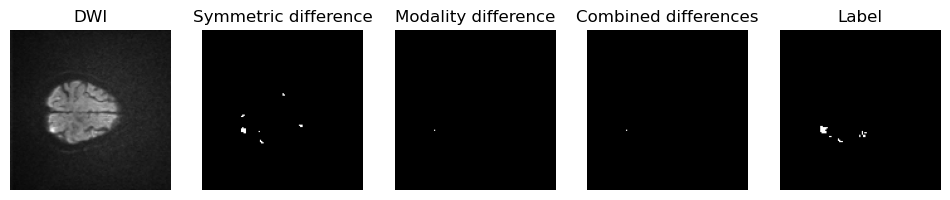

Dice: 0.0


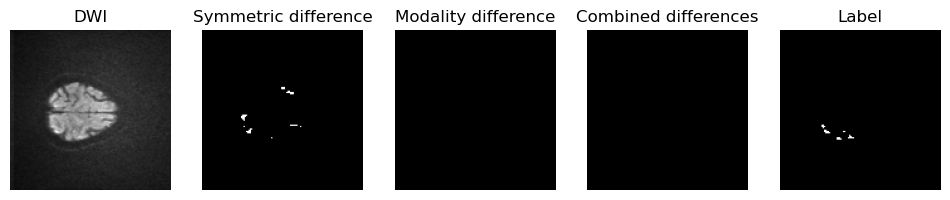

In [63]:
# The method uses a single value to create the segmentation:
g_value = 1.2 # Here I have tested different values and found 1.2 to give a good result.

for slice_idx in range(0,len(DWI_vol[0,0,:])):
    if np.sum(label_vol[:,:,slice_idx])> 0:
        DWI_slice = DWI_vol[:,:,slice_idx]
        ADC_slice = ADC_vol[:,:,slice_idx]
        b0_slice = b0_vol[:,:,slice_idx]
        DWI_slice_reg = DWI_vol_reg[:,:,slice_idx]
        label_slice = label_vol[:,:,slice_idx]

        # Use differences to create a segmentation mask:
        symDif, modDif, difDif = DifDif_segmentation(g_value)

        # Dice:
        areaOfOverlap = np.sum(difDif * label_slice)
        totalArea = np.sum(difDif).item() + np.sum(label_slice)
        dice = (2*areaOfOverlap)/totalArea
        print('Dice:',round(dice,3))

        # Plot:
        fig, axes = plt.subplots(1, 5, figsize=(12, 4))
        axes[0].imshow(DWI_slice, cmap='gray')
        axes[0].set_title('DWI')
        axes[1].imshow(symDif, cmap='gray')
        axes[1].set_title('Symmetric difference')
        axes[2].imshow(modDif, cmap='gray')
        axes[2].set_title('Modality difference')
        axes[3].imshow(difDif, cmap='gray')
        axes[3].set_title('Combined differences')
        axes[4].imshow(label_slice, cmap='gray')
        axes[4].set_title('Label')
        for ax in axes:
            ax.axis('off')
        plt.show()